In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import textwrap
import subprocess
import sys
import shlex
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import scipy
import monai
import dipy
import torch
import torch.nn.functional as F
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 1
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to False
    # in PyTorch 1.12 and later.
    torch.backends.cuda.matmul.allow_tf32 = True
    # See
    # <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
    # for details.

    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
        # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
        torch.backends.cudnn.allow_tf32 = True
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  1
CUDA Current Device  1
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24245MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:1


## Data Loading

In [4]:
def nib_im_loader(f):
    return nib.as_closest_canonical(nib.load(f))


def nib_fdata_loader(nib_im, dtype=np.float32, **get_fdata_kwargs):
    im = nib_im.get_fdata(**get_fdata_kwargs).astype(dtype)
    if len(im.shape) == 4:
        im = np.moveaxis(im, -1, 0)
    return im

In [5]:
test_subj_ids = list(
    map(
        str,
        [
            # holdout subjects that have been processed
            126426,
            191336,
            251833,
            581450,
            825048,
            # test set subjects
            110613,
            112112,
            123420,
            124422,
            126628,
            129028,
            130013,
            133019,
            134425,
            135225,
            138837,
            139637,
            139839,
            143830,
            144428,
            144933,
            148840,
            149539,
            150019,
            151526,
            153227,
            153732,
            155231,
            162329,
            187850,
            189349,
            192843,
            193239,
            198451,
            220721,
            268850,
            270332,
            299154,
            314225,
            316633,
            350330,
            368551,
            453542,
            480141,
            492754,
            497865,
            500222,
            519647,
            567961,
            571144,
            656253,
            656657,
            677968,
            683256,
            704238,
            727654,
            731140,
            765056,
            767464,
            917558,
            930449,
            972566,
            978578,
            993675,
            994273,
        ],
    )
)

In [6]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
results_dir = Path("/data/srv/outputs/pitn/results/runs")
tmp_results_dir = Path("/data/srv/outputs/pitn/results/tmp")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert results_dir.exists()
assert tmp_results_dir.exists()

In [7]:
# Specify model names and the root directory of the prediction images.
model_names = [
    "INR 2023-06-20T03_20_54__epoch_49_step_21701",
    "Static-CARN-CNN",
    "trilinear",
    "trilinear-fodf",
]
model_pred_root_dirs = [
    results_dir / "2023-06-20T13_25_29_inr-pred-test_native-res/INR",
    tmp_results_dir
    / "2023-06-23T11_22_36_static-shape_pred_native-res/static-shape_CNN",
    tmp_results_dir / "2023-06-23T17_16_50_trilin-pred_native-res/trilinear",
    tmp_results_dir / "2023-06-25T18_29_00_trilin-upsample-odf_2.00mm-1.25mm",
]

for p in model_pred_root_dirs:
    assert p.exists()

In [8]:
subj_data = Box(default_box=True)

for subj_id in test_subj_ids:
    d_i = Box(default_box=True)
    gt_fs = pitn.data.datasets2.HCPfODFINRDataset.get_fodf_subj_dict(
        subj_id, hcp_full_res_fodf_dir
    )

    d_i.gt.f.odf_coeff = gt_fs["fodf"]
    d_i.gt.f.brain_mask = gt_fs["mask"]
    d_i.gt.f.fivett = gt_fs["fivett"]
    d_i.gt.f.fixel.wm_peak_dirs = (
        d_i.gt.f.odf_coeff.parent / "fixel" / "wm_peak_dirs.nii.gz"
    )

    d_i.gt.nib.odf_coeff = nib_im_loader(d_i.gt.f.odf_coeff)
    d_i.gt.nib.brain_mask = nib_im_loader(d_i.gt.f.brain_mask)
    d_i.gt.nib.fivett = nib_im_loader(d_i.gt.f.fivett)
    d_i.gt.nib.fixel.wm_peak_dirs = nib_im_loader(d_i.gt.f.fixel.wm_peak_dirs)

    # Break up the fivett into the different tissues.
    fivett = nib_fdata_loader(d_i.gt.nib.fivett, bool, caching="unchanged")
    gm_mask = fivett[0:2].sum(0, keepdims=True).astype(bool)
    d_i.gt.gm_mask = gm_mask
    wm_mask = fivett[2:3]
    d_i.gt.wm_mask = wm_mask
    csf_mask = fivett[3:4]
    d_i.gt.csf_mask = csf_mask
    brain_mask = nib_fdata_loader(d_i.gt.nib.brain_mask, bool, caching="unchanged")
    brain_mask = brain_mask[None] | d_i.gt.gm_mask | d_i.gt.wm_mask | d_i.gt.csf_mask
    d_i.gt.brain_mask = brain_mask

    for name, root_dir in zip(model_names, model_pred_root_dirs):
        pred_f = pitn.utils.system.get_file_glob_unique(
            Path(root_dir).resolve(), f"*{subj_id}*.nii.gz"
        )
        d_i.models[name].f.odf_coeff = pred_f
        d_i.models[name].nib.odf_coeff = nib_im_loader(d_i.models[name].f.odf_coeff)

    subj_data[subj_id] = d_i
    print(subj_id, flush=True, end="...")

# Remove default_box status, to avoid some difficult-to-debug errors later.
_d = Box(default_box=False)
_d.merge_update(subj_data)
subj_data = _d

126426...191336...251833...581450...825048...110613...112112...123420...124422...126628...129028...130013...133019...134425...135225...138837...139637...139839...143830...144428...144933...148840...149539...150019...151526...153227...153732...155231...162329...187850...189349...192843...193239...198451...220721...268850...270332...299154...314225...316633...350330...368551...453542...480141...492754...497865...500222...519647...567961...571144...656253...656657...677968...683256...704238...727654...731140...765056...767464...917558...930449...972566...978578...993675...994273...

In [125]:
# print(m_and_s[m_and_s.measure == 'mean'].groupby('order').value.mean())
# print(m_and_s[m_and_s.measure == 'mean'].groupby('order').value.median())
# print(m_and_s[m_and_s.measure == 'std'].groupby('order').value.mean())
# print(m_and_s[m_and_s.measure == 'std'].groupby('order').value.median())

order
0    0.169445
2    0.001750
4    0.001825
6    0.000024
8    0.000020
Name: value, dtype: float32
order
0    0.168992
2   -0.000268
4    0.000834
6    0.000045
8    0.000013
Name: value, dtype: float32
order
0    0.054769
2    0.096614
4    0.061328
6    0.030408
8    0.010610
Name: value, dtype: float32
order
0    0.054531
2    0.096428
4    0.061017
6    0.030362
8    0.010657
Name: value, dtype: float32


In [127]:
# m = np.array(
#     [0.17]
#     + [0.002] * 5
#     + [0.002] * 9
#     + [0.0] * 13
#     + [0.0] * 17
# )
# sd = np.array(
#     [0.05]
#     + [0.1] * 5
#     + [0.06] * 9
#     + [0.03] * 13
#     + [0.01] * 17
# )
# m, sd

(array([0.17 , 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
        0.002, 0.002, 0.002, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.05, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
        0.06, 0.06, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
        0.03, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))

## Metrics

### Voxelwise

In [9]:
# All metrics must take in B x C x X x Y x Z input and target images, and a
# B x 1 x X x Y x Z bool mask, and return B x 1 x X x Y x Z voxel-wise metric images
# with the unmasked voxels set to 0.
sphere = dipy.data.get_sphere("repulsion724")
theta, phi = pitn.odf.get_torch_sample_sphere_coords(sphere, device, torch.float32)


def jsd_metric(input_odf_coeffs, target_odf_coeffs, mask, theta, phi):
    epsilon = 1e-5
    batch_size = input_odf_coeffs.shape[0]
    if batch_size != 1:
        raise NotImplementedError("ERROR: Batch size != 1 not supported")
    input_sphere_samples = pitn.odf.sample_sphere_coords(
        input_odf_coeffs * mask,
        theta=theta,
        phi=phi,
        sh_order=8,
        sh_order_dim=1,
        mask=mask,
        force_nonnegative=True,
    )
    n_sphere_samples = input_sphere_samples.shape[1]
    sphere_mask = mask.expand_as(input_sphere_samples)
    # Mask and reshape to (n_vox x batch_size) x n_prob_samples
    input_sphere_samples = einops.rearrange(
        input_sphere_samples[sphere_mask],
        "(b s v) -> (b v) s",
        b=batch_size,
        s=n_sphere_samples,
    )
    # Normalize to sum to 1.0, as a probability density.
    input_sphere_samples /= torch.maximum(
        torch.sum(input_sphere_samples, dim=1, keepdim=True),
        input_odf_coeffs.new_zeros(1) + epsilon,
    )
    target_sphere_samples = pitn.odf.sample_sphere_coords(
        target_odf_coeffs * mask,
        theta=theta,
        phi=phi,
        sh_order=8,
        sh_order_dim=1,
        mask=mask,
    )
    target_sphere_samples = einops.rearrange(
        target_sphere_samples[sphere_mask],
        "(b s v) -> (b v) s",
        b=batch_size,
        s=n_sphere_samples,
    )
    # Normalize to sum to 1.0, as a probability density.
    target_sphere_samples /= torch.maximum(
        torch.sum(target_sphere_samples, dim=1, keepdim=True),
        target_odf_coeffs.new_zeros(1) + epsilon,
    )

    Q_log_in = torch.log(input_sphere_samples.to(torch.float64))
    P_log_target = torch.log(target_sphere_samples.to(torch.float64))
    M_log = torch.log(
        (input_sphere_samples + target_sphere_samples).to(torch.float64) / 2
    )
    del input_sphere_samples, target_sphere_samples
    d_P_M = F.kl_div(M_log, P_log_target, reduction="none", log_target=True)
    # Implement batchmean per-voxel.
    # nan values from the kl divergence occur when the expected density is 0.0 and the
    # log is -inf. The 'contribution' of that element is 0 as the limit approaches 0,
    # so just adding the non-nan values should be valid.
    d_P_M = d_P_M.nansum(1, keepdim=True) / d_P_M.shape[1]

    d_Q_M = F.kl_div(M_log, Q_log_in, reduction="none", log_target=True)
    d_Q_M = d_Q_M.nansum(1, keepdim=True) / d_Q_M.shape[1]

    js_div = d_P_M / 2 + d_Q_M / 2
    js_div = einops.rearrange(js_div, "(b v) s -> (b s v)", b=batch_size, s=1)
    js_dist = torch.zeros_like(mask).to(input_odf_coeffs)
    js_dist.masked_scatter_(mask, torch.sqrt(js_div).to(torch.float32)).to(
        input_odf_coeffs
    )

    return js_dist


def mse_metric(y_pred, y, mask):
    masked_y_pred = y_pred.clone()
    masked_y = y.clone()
    m = mask.expand_as(masked_y)
    masked_y_pred[~m] = torch.nan
    masked_y[~m] = torch.nan
    se = F.mse_loss(masked_y_pred, masked_y, reduction="none")
    mse = torch.nanmean(se, dim=1, keepdim=True)
    return mse

In [10]:
metric_names = ("JSD", "MSE")
metric_fns = (partial(jsd_metric, theta=theta, phi=phi), mse_metric)

### Fixelwise

In [11]:
def mrtrix_fod2wm_peak_dirs(
    odf_coeffs: torch.Tensor,
    odf_coeffs_affine: np.ndarray,
    fivett_seg: torch.Tensor,
    fivett_seg_affine: np.ndarray,
    max_peaks: int,
    n_threads: int,
    fmls_integral=0,
    fmls_peak_value=0.1,
    fmls_lobe_merge_ratio=0.9,
) -> torch.Tensor:

    if odf_coeffs.ndim == 5:
        assert odf_coeffs.shape[0] == 1
        c = odf_coeffs[0]
        fivett = fivett_seg[0]
    else:
        c = odf_coeffs
        fivett = fivett_seg

    c = einops.rearrange(c.detach().cpu().numpy(), "c x y z -> x y z c")
    wm_mask = fivett.detach().cpu().numpy().astype(bool)[2]

    # Run everything in a temp directory, then load and store in memory.
    with tempfile.TemporaryDirectory() as tmpdirname:
        tmp_dir = Path(tmpdirname)

        fivett_f = tmp_dir / "fivett.nii.gz"
        wm_mask_f = tmp_dir / "wm_mask.nii.gz"
        odf_coeff_f = tmp_dir / "odf_coeffs.nii.gz"

        fixel_dir = tmp_dir / "fixel"
        peak_amp_f = fixel_dir / "peak_amp.mif"

        nib.save(nib.Nifti1Image(c, odf_coeffs_affine), odf_coeff_f)
        nib.save(
            nib.Nifti1Image(wm_mask.astype(np.uint8), fivett_seg_affine), wm_mask_f
        )

        fod2fixel_script = rf"""\
            fod2fixel -nthreads {n_threads} \
            {odf_coeff_f} \
            {fixel_dir} \
            -mask {wm_mask_f} \
            -peak_amp {peak_amp_f.name} \
            -dirpeak \
            -fmls_integral {fmls_integral} \
            -fmls_peak_value {fmls_peak_value} \
            -fmls_lobe_merge_ratio {fmls_lobe_merge_ratio}"""
        fod2fixel_script = textwrap.dedent(fod2fixel_script)
        fod2fixel_script = shlex.split(fod2fixel_script)
        fod2fixel_script = list(filter(lambda s: s != "\n", fod2fixel_script))
        subprocess.run(
            fod2fixel_script, check=True, timeout=900, stdout=subprocess.PIPE
        )

        wm_peak_dirs_f = fixel_dir / "wm_peak_dirs.nii.gz"
        fixel2peaks_script = rf"""\
            fixel2peaks -nthreads {n_threads} \
            {peak_amp_f} \
            {wm_peak_dirs_f} \
            -number {max_peaks} \
            -nan"""
        fixel2peaks_script = textwrap.dedent(fixel2peaks_script)
        fixel2peaks_script = shlex.split(fixel2peaks_script)
        fixel2peaks_script = list(filter(lambda s: s != "\n", fixel2peaks_script))
        subprocess.run(
            fixel2peaks_script, check=True, timeout=600, stdout=subprocess.PIPE
        )

        wm_peak_dirs_im = nib.load(wm_peak_dirs_f)
        wm_peak_dirs = wm_peak_dirs_im.get_fdata().astype(np.float32)
        wm_peak_dirs = torch.from_numpy(wm_peak_dirs).to(odf_coeffs)

    if odf_coeffs.ndim == 5:
        wm_peak_dirs = wm_peak_dirs[None]

    return wm_peak_dirs


def count_peaks(peak_dirs: torch.Tensor):
    if peak_dirs.shape[-1] % 3 != 0:
        raise ValueError(
            f"ERROR: Invalid direction tensor shape {tuple(peak_dirs.shape)}"
        )

    split_peak_dirs = torch.tensor_split(peak_dirs, peak_dirs.shape[-1] // 3, dim=-1)
    # b 1 x y z
    peak_count = torch.zeros_like(peak_dirs[:, None, ..., 0], dtype=torch.int)
    for peak_dir_i in split_peak_dirs:
        invalid_peak_mask = torch.isnan(peak_dir_i).any(dim=-1) | torch.isclose(
            peak_dir_i, peak_dir_i.new_zeros(1)
        ).all(dim=-1)
        invalid_peak_mask.unsqueeze_(1)
        peak_count += torch.where(invalid_peak_mask, 0, 1)

    return peak_count


def match_nvc_peaks_by_direction(
    input_peak_dirs_nvc: torch.Tensor,
    target_peak_dirs_nvc: torch.Tensor,
    wm_mask_wm_only: torch.Tensor,
):
    assert tuple(input_peak_dirs_nvc.shape) == tuple(target_peak_dirs_nvc.shape)
    assert input_peak_dirs_nvc.ndim == 3
    assert input_peak_dirs_nvc.shape[-1] == 3
    assert target_peak_dirs_nvc.ndim == 3
    assert target_peak_dirs_nvc.shape[-1] == 3
    assert (
        wm_mask_wm_only.numel()
        == target_peak_dirs_nvc.shape[1]
        == input_peak_dirs_nvc.shape[1]
    )

    x_broad = einops.repeat(
        input_peak_dirs_nvc,
        "n_x_peaks vox_flat coord -> n_x_peaks n_y_peaks vox_flat coord",
        n_y_peaks=target_peak_dirs_nvc.shape[0],
    )
    y_broad = einops.repeat(
        target_peak_dirs_nvc,
        "n_y_peaks vox_flat coord -> n_x_peaks n_y_peaks vox_flat coord",
        n_x_peaks=input_peak_dirs_nvc.shape[0],
    )

    xy_pair_dists = peak_arc_len(x_broad, y_broad)
    xy_pair_dists = einops.rearrange(
        xy_pair_dists, "n_x_peaks n_y_peaks vox_flat 1 -> vox_flat n_x_peaks n_y_peaks"
    )
    xy_pair_dists.nan_to_num_(nan=100.0)
    xy_pair_dists = xy_pair_dists.detach().cpu().numpy()
    x_vnc = einops.rearrange(
        input_peak_dirs_nvc.detach().cpu().numpy(),
        "n_x_peaks vox_flat coord -> vox_flat n_x_peaks coord",
    )
    x_sorted = np.zeros_like(x_vnc)

    n_vox = xy_pair_dists.shape[0]
    for i in range(n_vox):
        # n_x_peaks x n_y_peaks
        pair_dist_i = xy_pair_dists[i]
        row_idx, col_idx = scipy.optimize.linear_sum_assignment(
            pair_dist_i, maximize=False
        )
        x_sorted[i] = x_vnc[i, row_idx]

    x_sorted = einops.rearrange(
        torch.from_numpy(x_sorted).to(input_peak_dirs_nvc),
        "vox_flat n_x_peaks coord -> n_x_peaks vox_flat coord",
    )
    return x_sorted


def match_peaks_by_direction(
    input_peak_dirs: torch.Tensor, target_peak_dirs: torch.Tensor, mask: torch.Tensor
):
    assert input_peak_dirs.shape[0] == 1
    assert target_peak_dirs.shape[0] == 1
    assert mask.shape[0] == 1

    x = input_peak_dirs[mask[:, 0]].reshape(1, -1, input_peak_dirs.shape[-1])
    y = target_peak_dirs[mask[:, 0]].reshape(1, -1, target_peak_dirs.shape[-1])
    if (x.shape[-1] % 3 != 0) or (y.shape[-1] % 3 != 0):
        raise ValueError(
            f"ERROR: Invalid direction tensor shape {tuple(input_peak_dirs.shape)}, {tuple(target_peak_dirs.shape)}"
        )

    split_x = torch.tensor_split(x, x.shape[-1] // 3, dim=-1)
    y = einops.rearrange(
        y, "1 spatial (n_peaks coord) -> n_peaks spatial coord", coord=3
    )
    x_y_pair_dists = list()
    for x_i in split_x:
        x_i_broad = x_i.expand_as(y)
        pair_dist = peak_arc_len(x_i_broad, y)
        x_y_pair_dists.append(pair_dist[..., 0])

    x_y_pair_dists = torch.stack(x_y_pair_dists, dim=-1)
    # Higher than the max cosine distance possible.
    # x_y_pair_dists.nan_to_num_(nan=2.01)
    x_y_pair_dists = einops.rearrange(
        x_y_pair_dists, "n_y_peaks spatial n_x_peaks -> spatial n_x_peaks n_y_peaks"
    )
    x = (
        einops.rearrange(
            x, "1 spatial (n_peaks coord) -> n_peaks spatial coord", coord=3
        )
        .detach()
        .cpu()
        .numpy()
    )
    x_sorted = np.zeros((x.shape[1], x.shape[0], x.shape[2]), dtype=np.float32)
    pair_dists = np.nan_to_num(x_y_pair_dists.detach().cpu().numpy(), nan=2.01)
    for i in range(pair_dists.shape[0]):
        pair_dist_i = pair_dists[i]
        row_idx, col_idx = scipy.optimize.linear_sum_assignment(
            pair_dist_i, maximize=False
        )
        x_sorted[i, row_idx] = x[row_idx, i]
    x_sorted = einops.rearrange(
        x_sorted, "spatial n_peaks coord -> 1 spatial (n_peaks coord)"
    )
    x_sorted = torch.from_numpy(x_sorted).to(input_peak_dirs)
    sorted_vecs = torch.ones_like(input_peak_dirs) * torch.nan
    mask_broad = mask[:, 0, ..., None].expand_as(input_peak_dirs)
    sorted_vecs.masked_scatter_(mask_broad, x_sorted)

    return sorted_vecs


def peak_arc_len(input_dirs: torch.Tensor, target_dirs: torch.Tensor):
    scaled_dot_prod = F.cosine_similarity(input_dirs, target_dirs, dim=-1).unsqueeze(-1)
    # Clip to avoid nans in the arccos.
    scaled_dot_prod.clip_(-1 + 1e-6, 1 - 1e-6)
    return torch.arccos(scaled_dot_prod)

## Evaluation

### Voxel-Wise Metrics

In [ ]:
VOXEL_USE_CSV = False

In [ ]:
voxelwise_metrics_results_table = dict(
    subj_id=list(),
    model=list(),
    tissue_mask=list(),
    metric=list(),
    mean_value=list(),
    std_value=list(),
)

if VOXEL_USE_CSV:
    voxelwise_metrics_results_table = pd.read_csv("voxelwise_metrics_results.csv")
else:
    # for every subject
    for subj_id, d in subj_data.items():
        print(f"Starting {subj_id}", flush=True, end="...")
        # Load ground truth data and masks.
        gt_odf_coeff = nib_fdata_loader(
            d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
        )[None]
        gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

        brain_mask = d.gt.brain_mask
        brain_mask = torch.from_numpy(brain_mask).to(device)[None]
        wm_mask = d.gt.wm_mask
        wm_mask = torch.from_numpy(wm_mask).to(device)[None]
        gm_mask = d.gt.gm_mask
        gm_mask = torch.from_numpy(gm_mask).to(device)[None]
        csf_mask = d.gt.csf_mask
        csf_mask = torch.from_numpy(csf_mask).to(device)[None]

        # for every model
        for model_name, d_model in d.models.items():
            print(f"model {model_name}", flush=True, end="...")

            pred_odf_coeff = nib_fdata_loader(
                d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
            )[None]
            pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)

            gt_dims = gt_odf_coeff.shape[1]
            pred_dims = pred_odf_coeff.shape[1]
            brain_mask_dims = 1
            x = torch.cat(
                [pred_odf_coeff.cpu(), gt_odf_coeff.cpu(), brain_mask.cpu()], dim=1
            )

            # for every metric
            for metric_name, fn_metric in zip(metric_names, metric_fns):
                print(f"metric {metric_name}", flush=True, end="...")
                metric_vol = monai.inferers.sliding_window_inference(
                    x.cpu(),
                    roi_size=(64, 64, 64),
                    sw_batch_size=x.shape[0],
                    predictor=lambda x: fn_metric(
                        x[:, :pred_dims].to(device, non_blocking=True),
                        x[:, pred_dims : pred_dims + gt_dims].to(
                            device, non_blocking=True
                        ),
                        x[:, -brain_mask_dims:].bool().to(device, non_blocking=True),
                    ).cpu(),
                    overlap=0,
                ).cpu()
                # Square all distance values before taking the average.
                if metric_name != "MSE":
                    metric_vol = metric_vol**2
                    if not metric_name.startswith("MS"):
                        metric_name = f"MS{metric_name}"

                # for all tissue masks
                for tissue_type, mask in zip(
                    ("all", "wm", "gm", "csf"), (brain_mask, wm_mask, gm_mask, csf_mask)
                ):
                    m = mask.cpu().expand_as(metric_vol.cpu())
                    result = metric_vol[m]

                    result_mean = result.mean().detach().cpu().item()
                    result_std = torch.std(result).detach().cpu().item()
                    if np.isnan(result_mean) or np.isnan(result_std):
                        raise RuntimeError(
                            f"ERROR: NaN metric on {subj_id}, {model_name}, {tissue_type}, {metric_name}"
                        )
                    voxelwise_metrics_results_table["subj_id"].append(subj_id)
                    voxelwise_metrics_results_table["model"].append(model_name)
                    voxelwise_metrics_results_table["tissue_mask"].append(tissue_type)
                    voxelwise_metrics_results_table["metric"].append(metric_name)
                    voxelwise_metrics_results_table["mean_value"].append(result_mean)
                    voxelwise_metrics_results_table["std_value"].append(result_std)
        print()

    voxelwise_metrics_results_table = pd.DataFrame.from_dict(
        voxelwise_metrics_results_table
    )
    voxelwise_metrics_results_table.to_csv("voxelwise_metrics_results.csv", index=False)
voxelwise_metrics_results_table

In [ ]:
voxelwise_metrics_results_table[
    np.isnan(np.array(voxelwise_metrics_results_table.mean_value))
]

In [ ]:
plot_table = voxelwise_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table = plot_table[plot_table.tissue_mask.map(lambda s: s in {"all", "wm"})]

with sns.axes_style("whitegrid"):
    with sns.plotting_context("talk", font_scale=0.8):
        with mpl.rc_context(
            {
                "figure.autolayout": False,
                "figure.constrained_layout.use": False,
                "figure.subplot.left": 0.0,
                "figure.subplot.right": 1.0,
                "figure.subplot.top": 1.0,
                "figure.subplot.bottom": 0.0,
                "figure.subplot.wspace": 0.04,
                "figure.subplot.hspace": 0.04,
            }
        ):
            h = 3
            w = 7.7
            plt.figure(dpi=500, figsize=(w, h))  # , figsize=(3, 3*16/9))
            # plot_table = plot_table[plot_table.model != 'trilinear']
            g = sns.catplot(
                plot_table,
                y="model",
                x="mean_value",
                hue="model",
                col="metric",
                row="tissue_mask",
                sharex="col",
                # height=h,
                aspect=w / h,
                # kind="strip",
                # jitter=True,
                dodge=False,
                margin_titles=True,
                kind="violin",
                cut=0.5,
                width=0.9,
                # inner=None,
                # inner='stick',
                scale="width",
            )
            g

In [ ]:
plot_table = voxelwise_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table = plot_table[plot_table.tissue_mask.map(lambda s: s in {"all", "wm"})]

with sns.axes_style("whitegrid"):
    with sns.plotting_context("talk", font_scale=0.8):
        with mpl.rc_context(
            {
                "figure.autolayout": False,
                "figure.constrained_layout.use": False,
                "figure.subplot.left": 0.0,
                "figure.subplot.right": 1.0,
                "figure.subplot.top": 1.0,
                "figure.subplot.bottom": 0.0,
                "figure.subplot.wspace": 0.04,
                "figure.subplot.hspace": 0.04,
            }
        ):
            h = 3
            w = 7.7
            plt.figure(dpi=500, figsize=(w, h))  # , figsize=(3, 3*16/9))
            # plot_table = plot_table[plot_table.model != 'trilinear']
            g = sns.catplot(
                plot_table,
                y="model",
                x="std_value",
                hue="model",
                col="metric",
                row="tissue_mask",
                sharex="col",
                # height=h,
                aspect=w / h,
                # kind="strip",
                # jitter=True,
                # dodge=True,
                margin_titles=True,
                kind="violin",
                cut=0.5,
                width=0.9,
                # inner=None,
                inner="stick",
                scale="width",
            )
            g

### Fixel Metrics

In [12]:
FIXEL_USE_CSV = True

In [13]:
peak_metrics_results_table = dict(
    subj_id=list(),
    model=list(),
    n_pred_peaks=list(),
    n_target_peaks=list(),
    n_vox_target_wm=list(),
    n_vox_with_target_peaks=list(),
    n_vox_with_pred_peaks=list(),
    n_vox_with_pred_and_target_peaks=list(),
    metric=list(),
    mean_value=list(),
    std_value=list(),
)
if FIXEL_USE_CSV:
    peak_metrics_results_table = pd.read_csv("peak_metrics_results.csv")
else:
    if Path("pred_wm_fixel_peaks.npz").exists():
        subj_peak_data = np.load("pred_wm_fixel_peaks.npz", allow_pickle=True)[
            "peak_data"
        ].item()
        resave_subj_peak_data = False
    else:
        subj_peak_data = dict()
        resave_subj_peak_data = True
    # for every subject
    for subj_id, d in subj_data.items():
        print(f"Starting {subj_id}", flush=True, end="...\n")
        if subj_id not in subj_peak_data.keys():
            subj_peak_data[subj_id] = dict()
            resave_subj_peak_data = True
        # Load ground truth data and masks.
        gt_odf_coeff = nib_fdata_loader(
            d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
        )[None]
        gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

        brain_mask = d.gt.brain_mask
        brain_mask = torch.from_numpy(brain_mask).to(device)[None]
        wm_mask = d.gt.wm_mask
        wm_mask = torch.from_numpy(wm_mask).to(device)[None]
        fivett_seg = nib_fdata_loader(d.gt.nib.fivett, bool, caching="unchanged")
        fivett_seg = torch.from_numpy(fivett_seg).to(device)[None]

        peak_dirs = nib_fdata_loader(
            d.gt.nib.fixel.wm_peak_dirs, np.float32, caching="unchanged"
        )
        peak_dirs = torch.from_numpy(peak_dirs).to(device)[None]
        peak_dirs = einops.rearrange(
            peak_dirs, "1 (n_peaks coord) x y z -> 1 x y z (n_peaks coord)", coord=3
        )
        # Count shape of b 1 x y z
        peak_count = count_peaks(peak_dirs)
        peak_batch_peak_dirs = einops.rearrange(
            peak_dirs, "1 x y z (n_peaks coord) -> n_peaks x y z coord", coord=3
        )

        wm_mask_peaks_in_spatial_grid = einops.rearrange(
            wm_mask, "1 1 x y z -> 1 x y z 1"
        )
        # Shape `1 all_wm_spatial 1` to correspond to the `n_peaks all_wm_spatial 3`
        # peak directions later on.
        wm_mask_wm_only = wm_mask_peaks_in_spatial_grid[
            wm_mask_peaks_in_spatial_grid
        ].reshape(1, -1, 1)

        # Reduced shape of `n_peaks all_wm_spatial 3`
        peak_dirs_wm_only = peak_batch_peak_dirs[
            :, wm_mask_peaks_in_spatial_grid.squeeze(), :
        ]
        peak_count_wm_only = peak_count[
            :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
        ].unsqueeze(-1)

        unique_gt_peak_count = set(
            peak_count_wm_only.flatten().unique().detach().cpu().tolist()
        )

        # Delete these as they are not needed anymore, and to avoid confusion later on.
        del peak_dirs, peak_batch_peak_dirs, peak_count

        n_vox_target_wm = wm_mask_wm_only.sum().cpu().item()

        # for every model
        for model_name, d_model in d.models.items():
            print(f"model {model_name}", flush=True, end="...\n")
            if model_name not in subj_peak_data[subj_id].keys():
                subj_peak_data[subj_id][model_name] = dict()
                resave_subj_peak_data = True
            try:
                pred_dirs_wm_only = torch.from_numpy(
                    subj_peak_data[subj_id][model_name]["peaks"]
                ).to(peak_dirs_wm_only)
                pred_peak_count_wm_only = torch.from_numpy(
                    subj_peak_data[subj_id][model_name]["peak_count"]
                ).to(peak_count_wm_only)
            except KeyError:
                resave_subj_peak_data = True
                pred_odf_coeff = nib_fdata_loader(
                    d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
                )
                pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)[None]

                unsorted_pred_peak_dirs = mrtrix_fod2wm_peak_dirs(
                    pred_odf_coeff,
                    odf_coeffs_affine=d_model.nib.odf_coeff.affine,
                    fivett_seg=fivett_seg,
                    fivett_seg_affine=d.gt.nib.fivett.affine,
                    max_peaks=5,
                    n_threads=10,
                )
                print()

                unsorted_peak_batch_pred_peak_dirs = einops.rearrange(
                    unsorted_pred_peak_dirs,
                    "1 x y z (n_peaks coord) -> n_peaks x y z coord",
                    coord=3,
                )
                unsorted_pred_dirs_wm_only = unsorted_peak_batch_pred_peak_dirs[
                    :, wm_mask_peaks_in_spatial_grid.squeeze(), :
                ]
                pred_dirs_wm_only = match_nvc_peaks_by_direction(
                    unsorted_pred_dirs_wm_only,
                    peak_dirs_wm_only,
                    wm_mask_wm_only=wm_mask_wm_only,
                )

                # Arranging peaks by the target directions has no effect on the count of the
                # pred peaks.
                pred_peak_count = count_peaks(unsorted_pred_peak_dirs)
                pred_peak_count_wm_only = pred_peak_count[
                    :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
                ].unsqueeze(-1)

                subj_peak_data[subj_id][model_name]["peaks"] = (
                    pred_dirs_wm_only.detach().cpu().numpy()
                )
                subj_peak_data[subj_id][model_name]["peak_count"] = (
                    pred_peak_count_wm_only.detach().cpu().numpy()
                )

                del (
                    unsorted_pred_peak_dirs,
                    unsorted_peak_batch_pred_peak_dirs,
                    unsorted_pred_dirs_wm_only,
                    pred_peak_count,
                )
            unique_pred_peak_count = set(
                pred_peak_count_wm_only.flatten().unique().detach().cpu().tolist()
            )

            # for every peak count in the ground truth
            for num_gt_dirs_i in unique_gt_peak_count:
                mask_i = peak_count_wm_only == num_gt_dirs_i
                n_vox_gt_i = mask_i.sum().cpu().item()
                # for every peak count in the prediction
                for num_pred_dirs_j in unique_pred_peak_count:
                    print(
                        f"(GT {num_gt_dirs_i}, pred {num_pred_dirs_j})",
                        flush=True,
                        end="...",
                    )
                    mask_j = pred_peak_count_wm_only == num_pred_dirs_j
                    n_vox_pred_j = mask_j.sum().cpu().item()

                    top_k_peaks = min(num_gt_dirs_i, num_pred_dirs_j)

                    mask_ij = mask_i & mask_j
                    n_vox_ij = mask_ij.sum().cpu().item()

                    if not mask_ij.any():
                        result_mean = np.nan
                        result_std = np.nan
                    elif top_k_peaks == 0:
                        result_mean = np.nan
                        result_std = np.nan
                    else:
                        dirs_ij = peak_dirs_wm_only[:top_k_peaks, mask_ij.squeeze(), :]
                        pred_dirs_ij = pred_dirs_wm_only[
                            :top_k_peaks, mask_ij.squeeze(), :
                        ]

                        # Output shape `k_peaks n_wm_vox 1`
                        result = peak_arc_len(pred_dirs_ij, dirs_ij)
                        squared_result = result**2

                        result_mean = squared_result.mean().detach().cpu().item()
                        result_std = torch.std(squared_result).detach().cpu().item()
                        if np.isnan(result_mean):
                            raise RuntimeError(
                                f"ERROR: NaN metric on {subj_id}, {model_name}, {num_gt_dirs_i}, {num_pred_dirs_j}"
                            )
                    peak_metrics_results_table["subj_id"].append(subj_id)
                    peak_metrics_results_table["model"].append(model_name)
                    peak_metrics_results_table["n_pred_peaks"].append(num_pred_dirs_j)
                    peak_metrics_results_table["n_target_peaks"].append(num_gt_dirs_i)
                    peak_metrics_results_table["n_vox_target_wm"].append(
                        n_vox_target_wm
                    )
                    peak_metrics_results_table["n_vox_with_target_peaks"].append(
                        n_vox_gt_i
                    )
                    peak_metrics_results_table["n_vox_with_pred_peaks"].append(
                        n_vox_pred_j
                    )
                    peak_metrics_results_table[
                        "n_vox_with_pred_and_target_peaks"
                    ].append(n_vox_ij)
                    peak_metrics_results_table["metric"].append("MS arc length")
                    peak_metrics_results_table["mean_value"].append(result_mean)
                    peak_metrics_results_table["std_value"].append(result_std)

            print()
        print()

    peak_metrics_results_table = pd.DataFrame.from_dict(peak_metrics_results_table)
    peak_metrics_results_table.to_csv("peak_metrics_results.csv", index=False)
    if resave_subj_peak_data:
        np.savez_compressed("pred_wm_fixel_peaks.npz", peak_data=subj_peak_data)
peak_metrics_results_table

,subj_id,model,n_pred_peaks,n_target_peaks,n_vox_target_wm,n_vox_with_target_peaks,n_vox_with_pred_peaks,n_vox_with_pred_and_target_peaks,metric,mean_value,std_value
0,126426,INR 2023-06-20T03_20_54__epoch_49_step_21701,0,0,189766,4026,22701,3825,MS arc length,NaN,NaN
1,126426,INR 2023-06-20T03_20_54__epoch_49_step_21701,1,0,189766,4026,131525,199,MS arc length,NaN,NaN
2,126426,INR 2023-06-20T03_20_54__epoch_49_step_21701,2,0,189766,4026,32767,1,MS arc length,NaN,NaN
3,126426,INR 2023-06-20T03_20_54__epoch_49_step_21701,3,0,189766,4026,2313,0,MS arc length,NaN,NaN
4,126426,INR 2023-06-20T03_20_54__epoch_49_step_21701,4,0,189766,4026,342,1,MS arc length,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9355,994273,trilinear-fodf,1,5,265953,3262,118092,172,MS arc length,1.467818,2.575012
9356,994273,trilinear-fodf,2,5,265953,3262,104927,644,MS arc length,1.597435,2.173100
9357,994273,trilinear-fodf,3,5,265953,3262,27204,894,MS arc length,1.746034,2.038365
9358,994273,trilinear-fodf,4,5,265953,3262,5698,644,MS arc length,1.914342,1.998575


In [ ]:
# # Cosine distances also include "overestimates" and "underestimates" in peak count.
# penalized_peak_metrics_results_table = dict(
#     subj_id=list(),
#     model=list(),
#     n_target_peaks=list(),
#     n_vox_target_wm=list(),
#     n_target_vox_with_target_peaks=list(),
#     metric=list(),
#     mean_value=list(),
#     median_value=list(),
#     std_value=list(),
# )
# if FIXEL_USE_CSV:
#     penalized_peak_metrics_results_table = pd.read_csv(
#         "penalized_peak_metrics_results.csv"
#     )
# else:
#     # for every subject
#     for subj_id, d in subj_data.items():
#         print(f"Starting {subj_id}", flush=True, end="...\n")
#         all_subj_results = dict() #!
#         # Load ground truth data and masks.
#         gt_odf_coeff = nib_fdata_loader(
#             d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
#         )[None]
#         gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

#         brain_mask = d.gt.brain_mask
#         brain_mask = torch.from_numpy(brain_mask).to(device)[None]
#         wm_mask = d.gt.wm_mask
#         wm_mask = torch.from_numpy(wm_mask).to(device)[None]
#         fivett_seg = nib_fdata_loader(d.gt.nib.fivett, bool, caching="unchanged")
#         fivett_seg = torch.from_numpy(fivett_seg).to(device)[None]

#         peak_dirs = nib_fdata_loader(
#             d.gt.nib.fixel.wm_peak_dirs, np.float32, caching="unchanged"
#         )
#         peak_dirs = torch.from_numpy(peak_dirs).to(device)[None]
#         peak_dirs = einops.rearrange(
#             peak_dirs, "1 (n_peaks coord) x y z -> 1 x y z (n_peaks coord)", coord=3
#         )
#         # Count shape of b 1 x y z
#         peak_count = count_peaks(peak_dirs)
#         peak_batch_peak_dirs = einops.rearrange(
#             peak_dirs, "1 x y z (n_peaks coord) -> n_peaks x y z coord", coord=3
#         )

#         wm_mask_peaks_in_spatial_grid = einops.rearrange(
#             wm_mask, "1 1 x y z -> 1 x y z 1"
#         )
#         # Shape `1 all_wm_spatial 1` to correspond to the `n_peaks all_wm_spatial 3`
#         # peak directions later on.
#         wm_mask_wm_only = wm_mask_peaks_in_spatial_grid[
#             wm_mask_peaks_in_spatial_grid
#         ].reshape(1, -1, 1)

#         # Reduced shape of `n_peaks all_wm_spatial 3`
#         peak_dirs_wm_only = peak_batch_peak_dirs[
#             :, wm_mask_peaks_in_spatial_grid.squeeze(), :
#         ]
#         peak_count_wm_only = peak_count[
#             :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
#         ].unsqueeze(-1)

#         unique_gt_peak_count = set(
#             peak_count_wm_only.flatten().unique().detach().cpu().tolist()
#         )

#         # Delete these as they are not needed anymore, and to avoid confusion later on.
#         del peak_dirs, peak_batch_peak_dirs, peak_count

#         n_vox_target_wm = wm_mask_wm_only.sum().cpu().item()

#         # for every model
#         for model_name, d_model in d.models.items():
#             print(f"model {model_name}", flush=True, end="...\n")

#             pred_odf_coeff = nib_fdata_loader(
#                 d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
#             )
#             pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)[None]

#             unsorted_pred_peak_dirs = mrtrix_fod2wm_peak_dirs(
#                 pred_odf_coeff,
#                 odf_coeffs_affine=d_model.nib.odf_coeff.affine,
#                 fivett_seg=fivett_seg,
#                 fivett_seg_affine=d.gt.nib.fivett.affine,
#                 max_peaks=5,
#                 n_threads=20,
#             )
#             print()

#             unsorted_peak_batch_pred_peak_dirs = einops.rearrange(
#                 unsorted_pred_peak_dirs,
#                 "1 x y z (n_peaks coord) -> n_peaks x y z coord",
#                 coord=3,
#             )
#             unsorted_pred_dirs_wm_only = unsorted_peak_batch_pred_peak_dirs[
#                 :, wm_mask_peaks_in_spatial_grid.squeeze(), :
#             ]
#             pred_dirs_wm_only = match_nvc_peaks_by_direction(
#                 unsorted_pred_dirs_wm_only,
#                 peak_dirs_wm_only,
#                 wm_mask_wm_only=wm_mask_wm_only,
#             )

#             # Arranging peaks by the target directions has no effect on the count of the
#             # pred peaks.
#             pred_peak_count = count_peaks(unsorted_pred_peak_dirs)
#             pred_peak_count_wm_only = pred_peak_count[
#                 :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
#             ].unsqueeze(-1)
#             unique_pred_peak_count = set(
#                 pred_peak_count_wm_only.flatten().unique().detach().cpu().tolist()
#             )

#             del (
#                 unsorted_pred_peak_dirs,
#                 unsorted_peak_batch_pred_peak_dirs,
#                 unsorted_pred_dirs_wm_only,
#                 pred_peak_count,
#             )
#             all_subj_results[model_name] = list() #!
#             # for every peak count in the ground truth
#             for num_gt_dirs_i in unique_gt_peak_count:
#                 mask_i = peak_count_wm_only == num_gt_dirs_i
#                 n_vox_gt_i = mask_i.sum().cpu().item()

#                 dirs_i = peak_dirs_wm_only[:, mask_i.squeeze(), :]
#                 pred_dirs_i = pred_dirs_wm_only[:, mask_i.squeeze(), :]

#                 # Output shape `x_peaks n_wm_vox 1`
#                 result = peak_cos_distance(pred_dirs_i, dirs_i)
#                 # Here, a NaN marks a score that will not be considered at all. A
#                 # distance of 2.0 would be "worst case", and a distance of 0 would
#                 # be "best case."
#                 # Assume
#                 peak_diff = pred_peak_count_wm_only[mask_i] - num_gt_dirs_i
#                 for diff in peak_diff.flatten().unique().cpu().tolist():
#                     if diff == 0:
#                         continue
#                     diff_mask = (peak_diff == diff).flatten()
#                     # Assign the cosine distance of the "off target" peak to the max
#                     # value possible as a penalty.
#                     result[num_gt_dirs_i + diff - 1, diff_mask] = 2.0
#                 all_subj_results[model_name].append(result.cpu().numpy()) #!

#                 # Measure mean per-fixel, then mean over all voxels.
#                 result_mean = torch.nanmean(result, dim=0)
#                 result_mean = torch.nanmean(result_mean).detach().cpu().item()
#                 # Median and std are computed over all non-nan fixels.
#                 result_median = torch.nanmedian(result).detach().cpu().item()
#                 result_std = np.nanstd(result.cpu().numpy()).item()

#                 # if np.isnan(result_mean):
#                 #     raise RuntimeError(
#                 #         f"ERROR: NaN metric on {subj_id}, {model_name}, {num_gt_dirs_i}, {num_pred_dirs_j}"
#                 #     )
#                 penalized_peak_metrics_results_table["subj_id"].append(subj_id)
#                 penalized_peak_metrics_results_table["model"].append(model_name)
#                 penalized_peak_metrics_results_table["n_target_peaks"].append(
#                     num_gt_dirs_i
#                 )
#                 penalized_peak_metrics_results_table["n_vox_target_wm"].append(
#                     n_vox_target_wm
#                 )
#                 penalized_peak_metrics_results_table[
#                     "n_target_vox_with_target_peaks"
#                 ].append(n_vox_gt_i)
#                 penalized_peak_metrics_results_table["metric"].append("cosine distance")
#                 penalized_peak_metrics_results_table["mean_value"].append(result_mean)
#                 penalized_peak_metrics_results_table["median_value"].append(
#                     result_median
#                 )
#                 penalized_peak_metrics_results_table["std_value"].append(result_std)

#             print()
#         print()

#     penalized_peak_metrics_results_table = pd.DataFrame.from_dict(
#         penalized_peak_metrics_results_table
#     )
#     penalized_peak_metrics_results_table.to_csv(
#         "penalized_peak_metrics_results.csv", index=False
#     )
# penalized_peak_metrics_results_table

In [ ]:
# plot_table = penalized_peak_metrics_results_table.copy()
# plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
# sns.catplot(
#     plot_table,
#     x='n_target_peaks',
#     y='mean_value',
#     hue='model',
# )

<Figure size 1200x800 with 0 Axes>

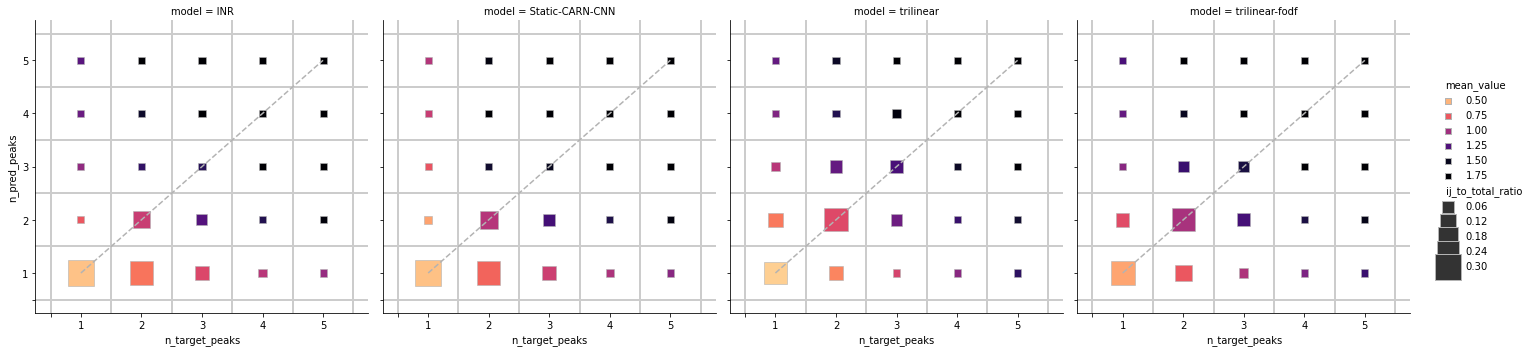

In [122]:
plot_table = peak_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
plot_table = plot_table[plot_table.n_pred_peaks > 0]
plot_table = plot_table[plot_table.n_target_peaks > 0]
plot_table["ij_to_total_ratio"] = (
    plot_table.n_vox_with_pred_and_target_peaks / plot_table.n_vox_target_wm
)
plot_table = plot_table.groupby(["n_target_peaks", "n_pred_peaks", "model"]).mean(
    numeric_only=True
)
min_ratio = plot_table.ij_to_total_ratio.min()
max_ratio = plot_table.ij_to_total_ratio.max()
min_max_ratio_ratio = min_ratio / max_ratio
# with sns.axes_style("whitegrid"):
with mpl.rc_context({"scatter.marker": "s"}):
    plt.figure(dpi=200)
    g = sns.relplot(
        plot_table,
        x="n_target_peaks",
        y="n_pred_peaks",
        hue="mean_value",
        col="model",
        kind="scatter",
        size="ij_to_total_ratio",
        hue_norm=(0.3, np.pi / 2),
        edgecolor="0.7",
        sizes=((2000 * min_max_ratio_ratio) + 50, 2050),
        size_norm=(0.01, 1.0),
        palette="magma_r",
        # marker='s',
    )

    grid_ls = sns.axes_style("whitegrid")["grid.linestyle"]
    grid_color = sns.axes_style("whitegrid")["grid.color"]
    for l_x in np.arange(0.5, 6.5):
        for l_y in np.arange(0.5, 6.5):
            g = g.refline(x=l_x, y=l_x, ls=grid_ls, color=grid_color, zorder=1.0)

    for ax in g.axes.flat:
        ax.plot([1, 5], [1, 5], color="0.7", ls="--", zorder=1000)
        ax.set_xticks([0.5] + np.arange(1, 6).tolist())
        ax.set_yticks([0.5] + np.arange(1, 6).tolist())
        ax.set_xticklabels([""] + np.arange(1, 6).tolist())
        ax.set_yticklabels([""] + np.arange(1, 6).tolist())
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")
    g

<Figure size 1200x800 with 0 Axes>

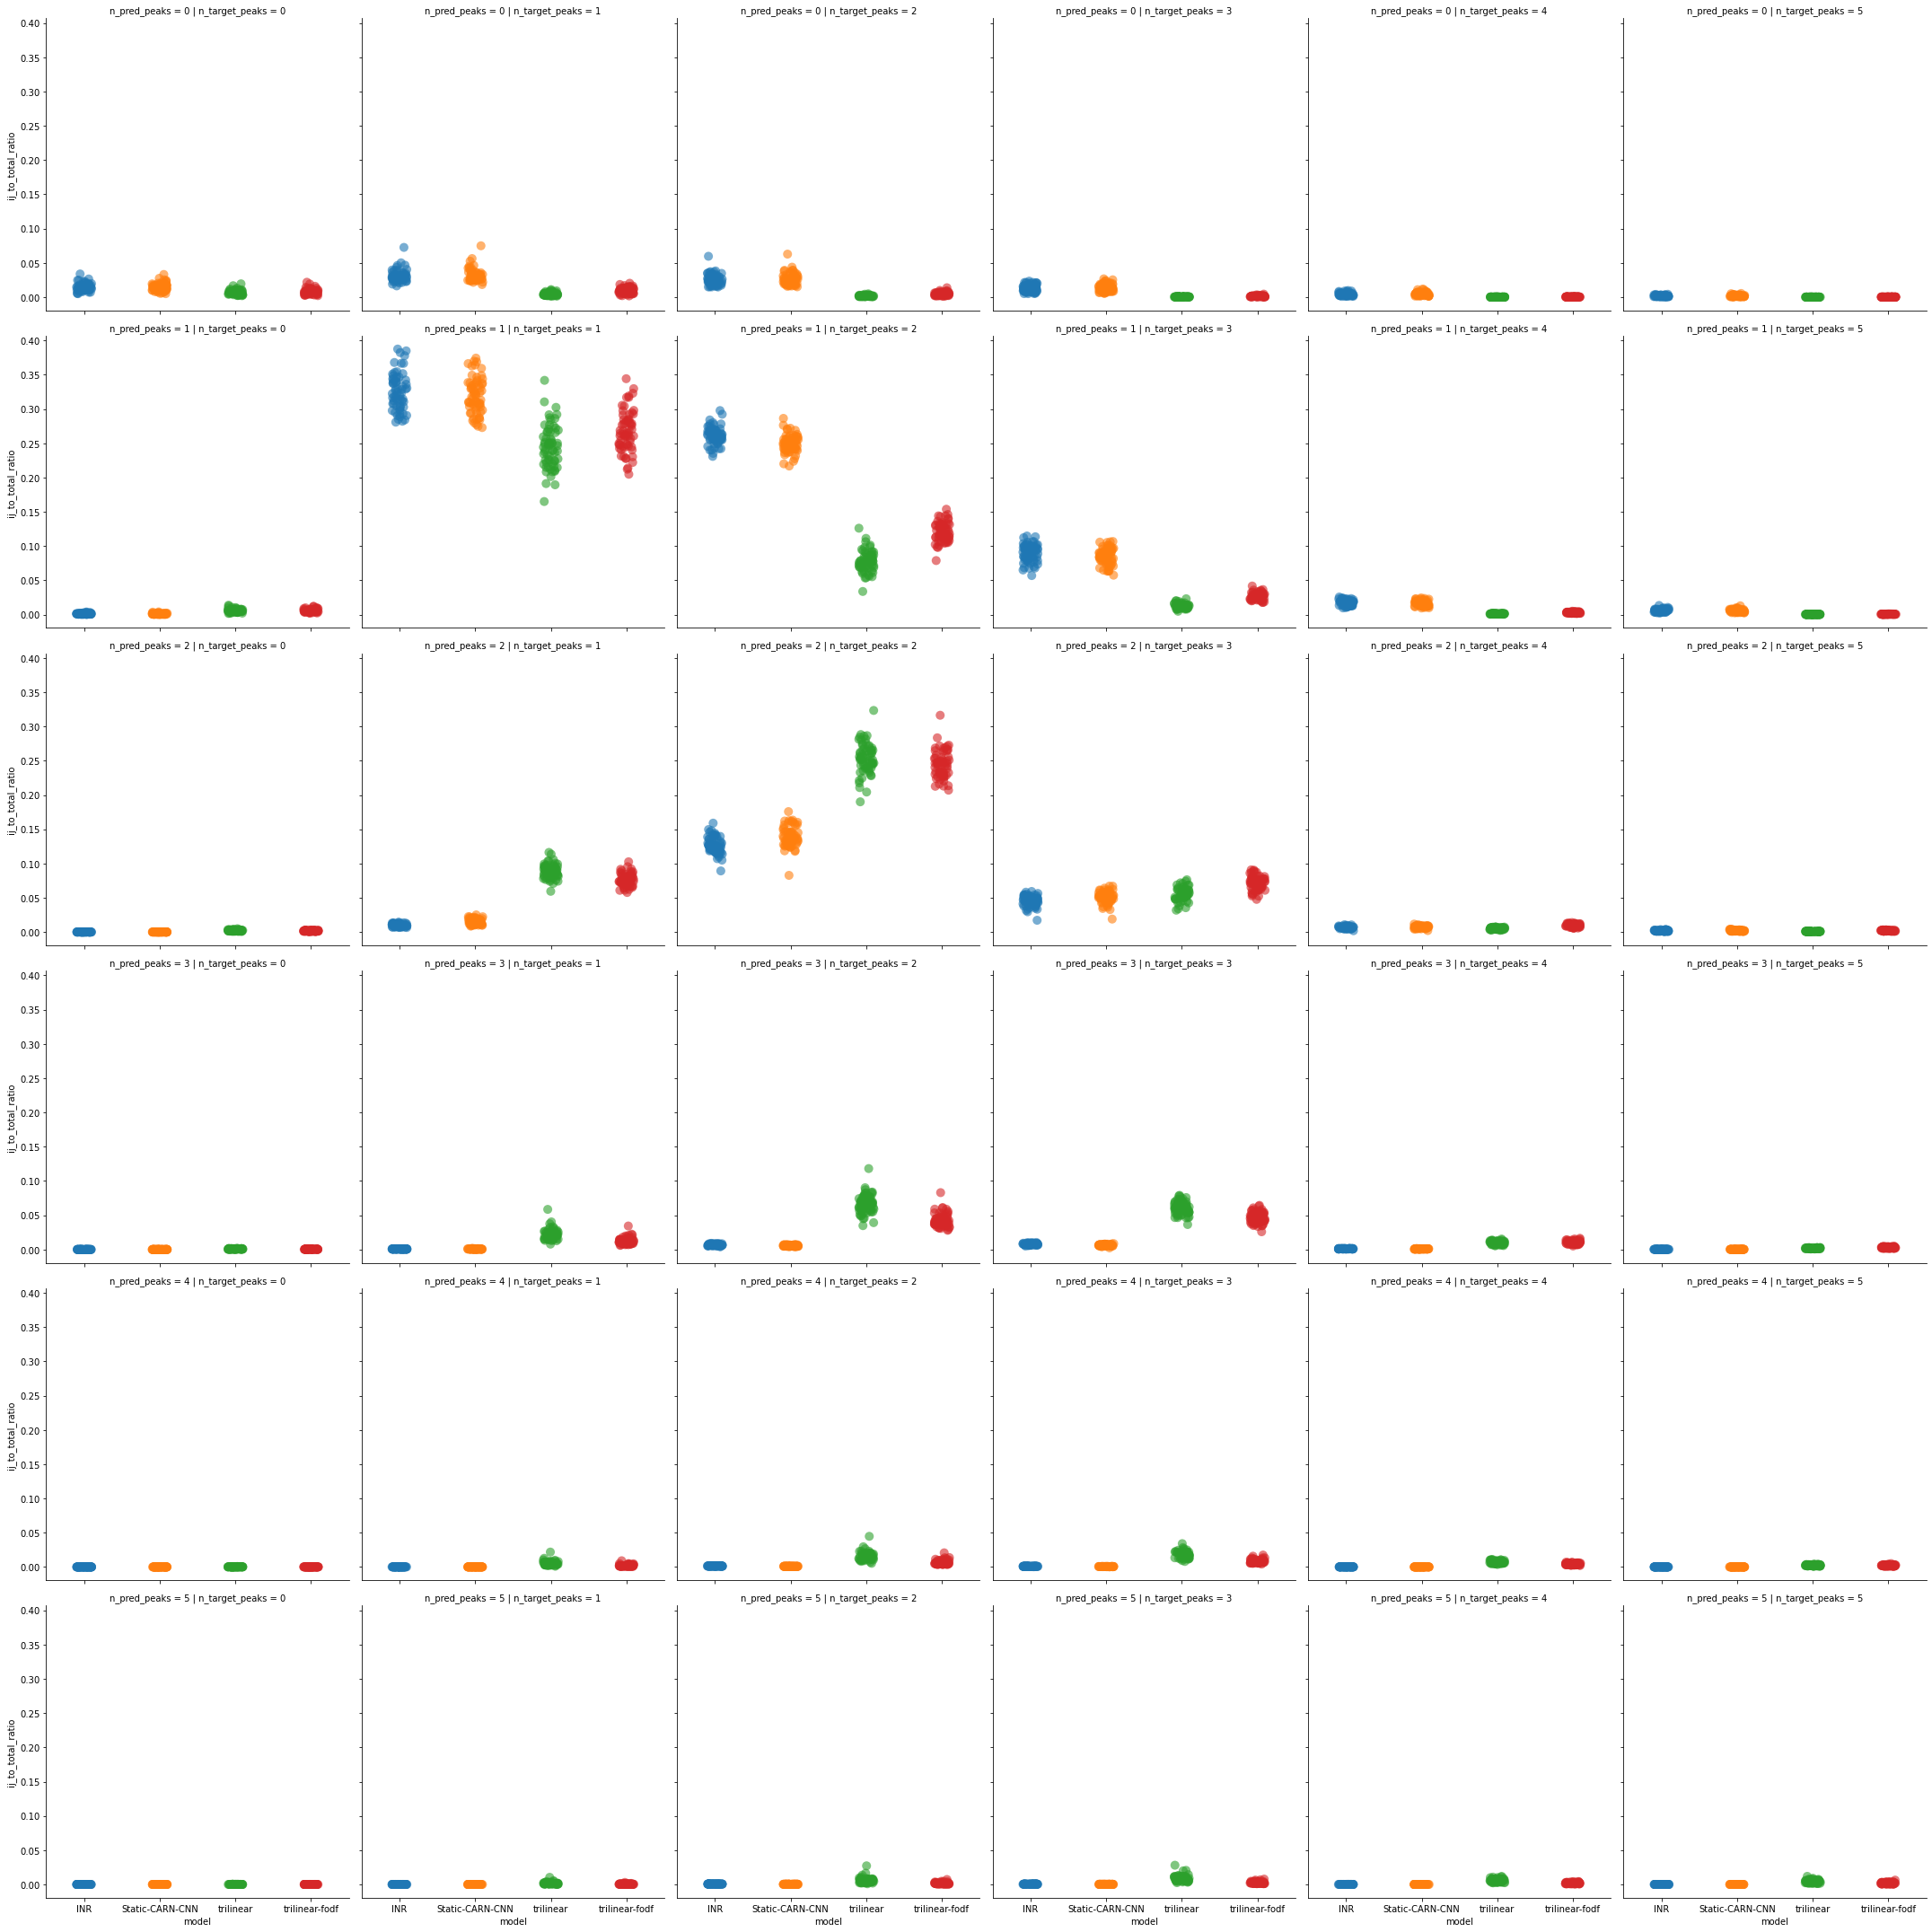

In [14]:
plot_table = peak_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
# plot_table = plot_table[plot_table.n_pred_peaks <= 3]
# plot_table = plot_table[plot_table.n_target_peaks <= 3]
plot_table["ij_to_total_ratio"] = (
    plot_table.n_vox_with_pred_and_target_peaks / plot_table.n_vox_target_wm
)
plt.figure(dpi=200)
sns.catplot(
    plot_table,
    x="model",
    y="ij_to_total_ratio",
    hue="model",
    # sharey='row',
    kind="strip",
    row="n_pred_peaks",
    col="n_target_peaks",
    margin_titles=True,
    size=10.0,
    alpha=0.6,
)

<Figure size 1200x800 with 0 Axes>

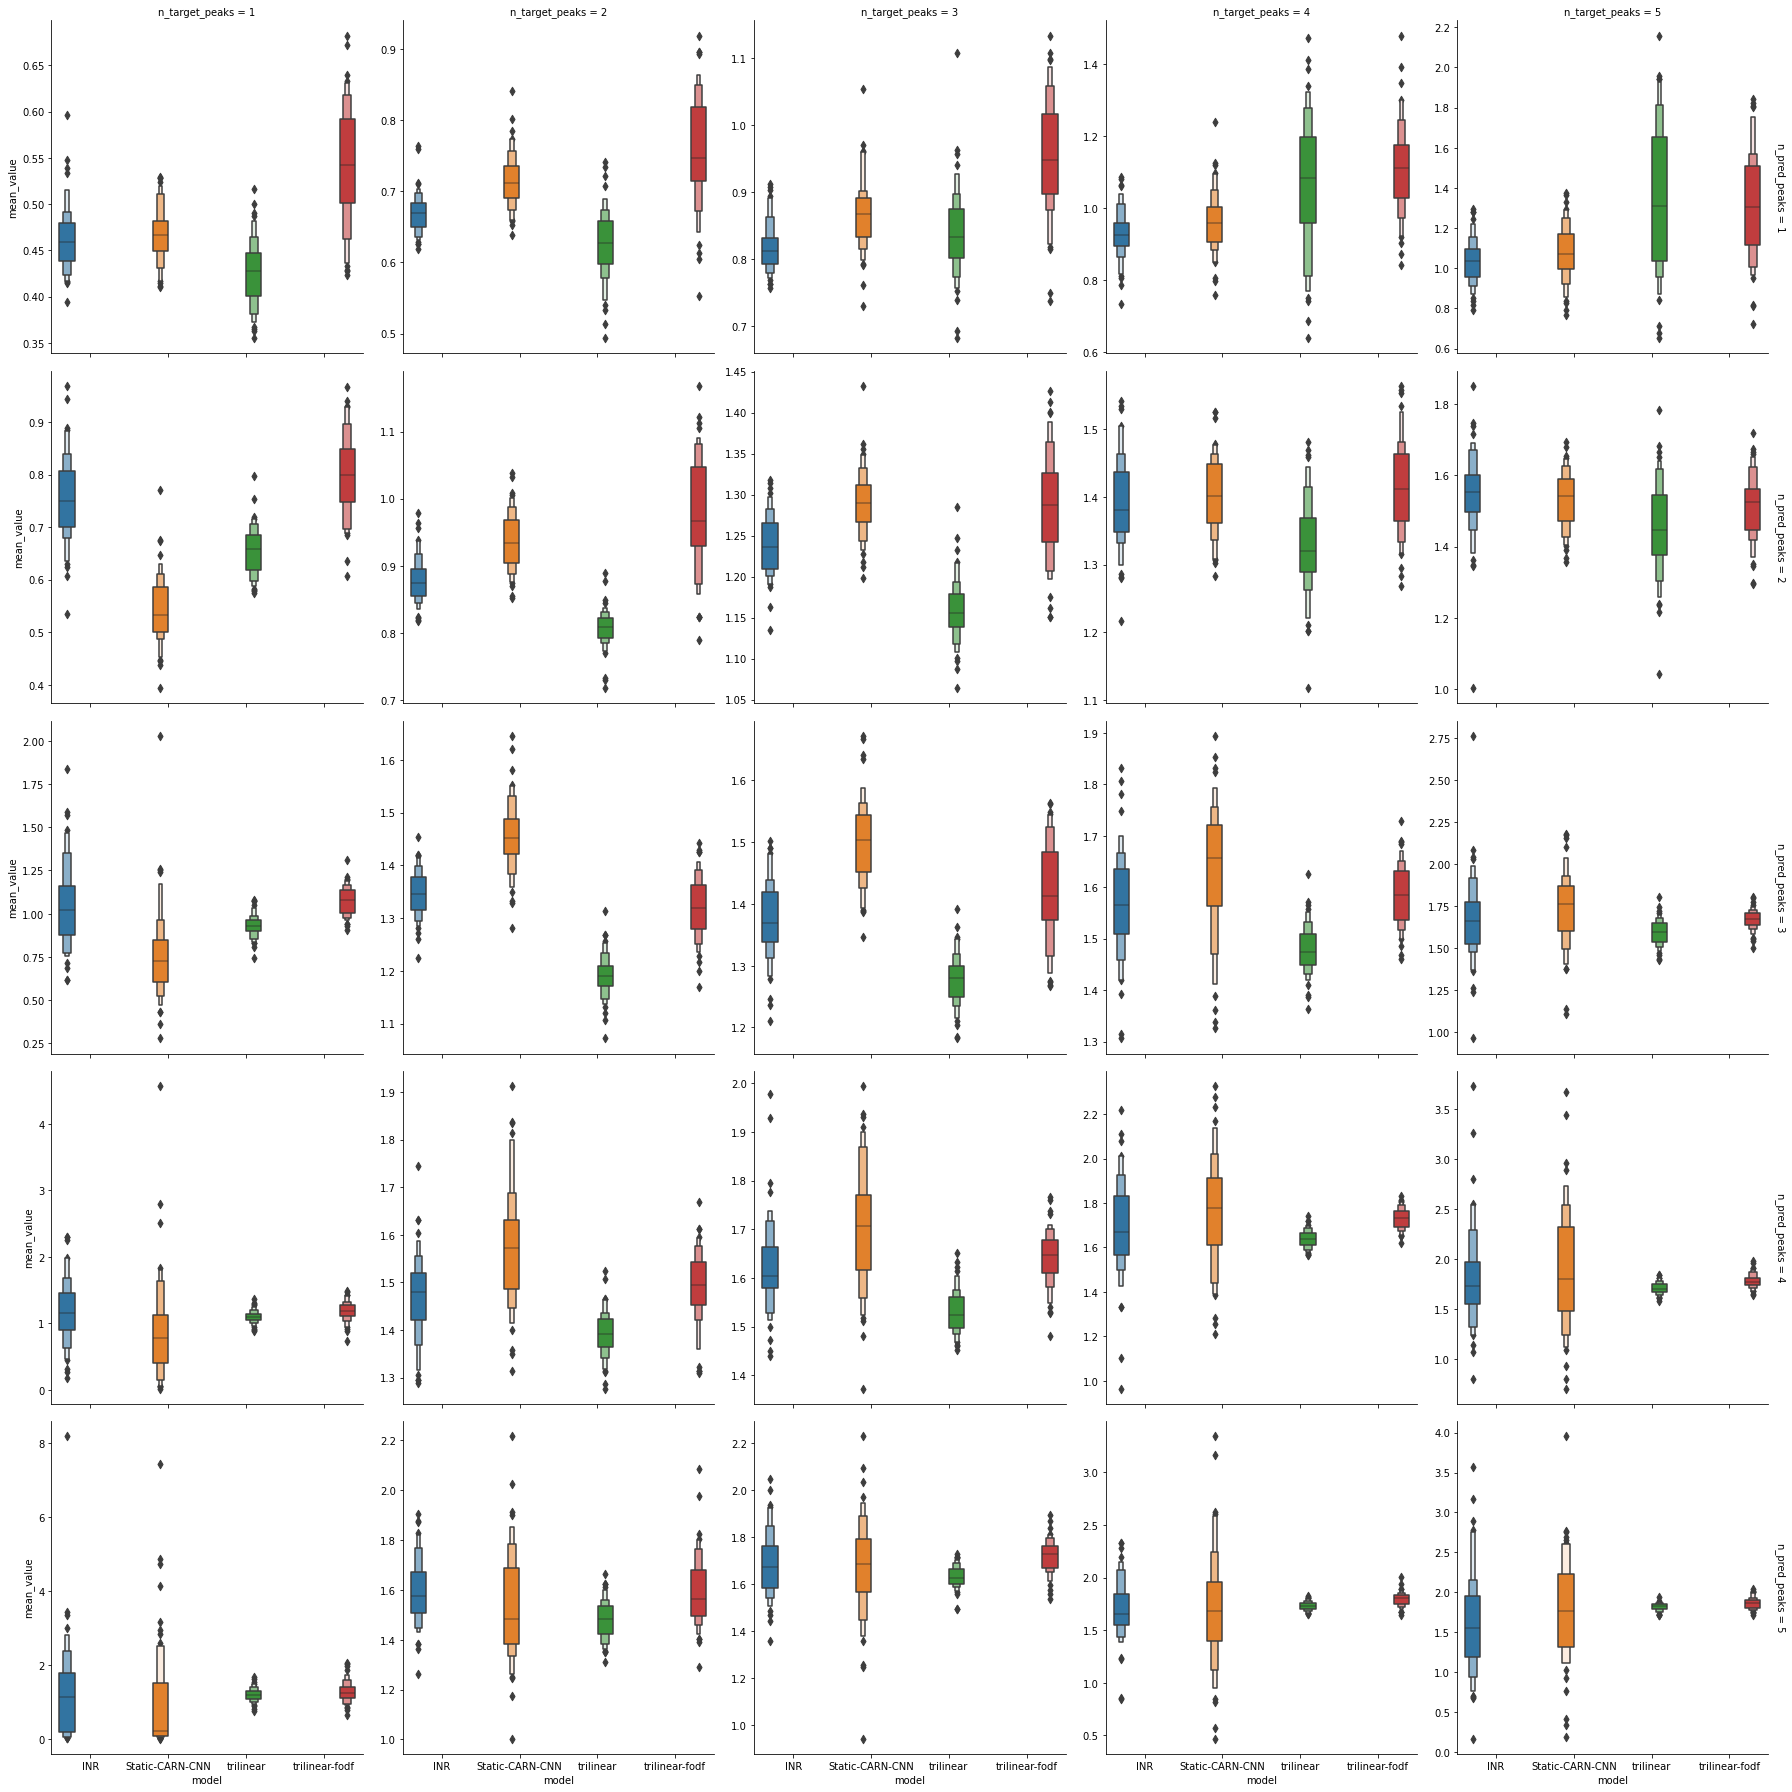

In [15]:
plot_table = peak_metrics_results_table.copy()
plot_table.model[plot_table.model.map(lambda n: "inr" in n.casefold())] = "INR"
# plot_table = plot_table[plot_table.n_pred_peaks <= 3]
plot_table = plot_table[plot_table.n_pred_peaks > 0]
# plot_table = plot_table[plot_table.n_target_peaks <= 3]
plot_table = plot_table[plot_table.n_target_peaks > 0]
# plot_table = plot_table[plot_table.n_target_peaks == plot_table.n_pred_peaks]

plt.figure(dpi=200)
sns.catplot(
    plot_table,
    x="model",
    y="mean_value",
    hue="model",
    sharey=False,
    col="n_target_peaks",
    row="n_pred_peaks",
    margin_titles=True,
    kind="boxen",
    # cut=0.5,
    # width=0.9,
    # inner='stick',
    # scale="count",
)

In [ ]:
# if Path("pred_wm_fixel_peaks.npz").exists():
#     subj_peak_data = np.load("pred_wm_fixel_peaks.npz", allow_pickle=True)[
#         "peak_data"
#     ].item()
#     resave_subj_peak_data = False
# else:
#     subj_peak_data = dict()
#     resave_subj_peak_data = True
# # for every subject
# # for subj_id, d in subj_data.items():
# for subj_id, d in (581450,): #!DEBUG
#     print(f"Starting {subj_id}", flush=True, end="...\n")
#     if subj_id not in subj_peak_data.keys():
#         subj_peak_data[subj_id] = dict()
#         resave_subj_peak_data = True
#     # Load ground truth data and masks.
#     gt_odf_coeff = nib_fdata_loader(
#         d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
#     )[None]
#     gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

#     brain_mask = d.gt.brain_mask
#     brain_mask = torch.from_numpy(brain_mask).to(device)[None]
#     wm_mask = d.gt.wm_mask
#     wm_mask = torch.from_numpy(wm_mask).to(device)[None]
#     fivett_seg = nib_fdata_loader(d.gt.nib.fivett, bool, caching="unchanged")
#     fivett_seg = torch.from_numpy(fivett_seg).to(device)[None]

#     peak_dirs = nib_fdata_loader(
#         d.gt.nib.fixel.wm_peak_dirs, np.float32, caching="unchanged"
#     )
#     peak_dirs = torch.from_numpy(peak_dirs).to(device)[None]
#     peak_dirs = einops.rearrange(
#         peak_dirs, "1 (n_peaks coord) x y z -> 1 x y z (n_peaks coord)", coord=3
#     )
#     # Count shape of b 1 x y z
#     peak_count = count_peaks(peak_dirs)
#     peak_batch_peak_dirs = einops.rearrange(
#         peak_dirs, "1 x y z (n_peaks coord) -> n_peaks x y z coord", coord=3
#     )

#     wm_mask_peaks_in_spatial_grid = einops.rearrange(
#         wm_mask, "1 1 x y z -> 1 x y z 1"
#     )
#     # Shape `1 all_wm_spatial 1` to correspond to the `n_peaks all_wm_spatial 3`
#     # peak directions later on.
#     wm_mask_wm_only = wm_mask_peaks_in_spatial_grid[
#         wm_mask_peaks_in_spatial_grid
#     ].reshape(1, -1, 1)

#     # Reduced shape of `n_peaks all_wm_spatial 3`
#     peak_dirs_wm_only = peak_batch_peak_dirs[
#         :, wm_mask_peaks_in_spatial_grid.squeeze(), :
#     ]
#     peak_count_wm_only = peak_count[
#         :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
#     ].unsqueeze(-1)

#     unique_gt_peak_count = set(
#         peak_count_wm_only.flatten().unique().detach().cpu().tolist()
#     )

#     # Delete these as they are not needed anymore, and to avoid confusion later on.
#     del peak_dirs, peak_batch_peak_dirs, peak_count

#     n_vox_target_wm = wm_mask_wm_only.sum().cpu().item()

#     # for every model
#     for model_name, d_model in d.models.items():
#         print(f"model {model_name}", flush=True, end="...\n")
#         if model_name not in subj_peak_data[subj_id].keys():
#             subj_peak_data[subj_id][model_name] = dict()
#             resave_subj_peak_data = True
#         try:
#             pred_dirs_wm_only = torch.from_numpy(
#                 subj_peak_data[subj_id][model_name]["peaks"]
#             ).to(peak_dirs_wm_only)
#             pred_peak_count_wm_only = torch.from_numpy(
#                 subj_peak_data[subj_id][model_name]["peak_count"]
#             ).to(peak_count_wm_only)
#         except KeyError:
#             resave_subj_peak_data = True
#             pred_odf_coeff = nib_fdata_loader(
#                 d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
#             )
#             pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)[None]

#             unsorted_pred_peak_dirs = mrtrix_fod2wm_peak_dirs(
#                 pred_odf_coeff,
#                 odf_coeffs_affine=d_model.nib.odf_coeff.affine,
#                 fivett_seg=fivett_seg,
#                 fivett_seg_affine=d.gt.nib.fivett.affine,
#                 max_peaks=5,
#                 n_threads=20,
#             )
#             print()

#             unsorted_peak_batch_pred_peak_dirs = einops.rearrange(
#                 unsorted_pred_peak_dirs,
#                 "1 x y z (n_peaks coord) -> n_peaks x y z coord",
#                 coord=3,
#             )
#             unsorted_pred_dirs_wm_only = unsorted_peak_batch_pred_peak_dirs[
#                 :, wm_mask_peaks_in_spatial_grid.squeeze(), :
#             ]
#             pred_dirs_wm_only = match_nvc_peaks_by_direction(
#                 unsorted_pred_dirs_wm_only,
#                 peak_dirs_wm_only,
#                 wm_mask_wm_only=wm_mask_wm_only,
#             )

#             # Arranging peaks by the target directions has no effect on the count of the
#             # pred peaks.
#             pred_peak_count = count_peaks(unsorted_pred_peak_dirs)
#             pred_peak_count_wm_only = pred_peak_count[
#                 :, 0, wm_mask_peaks_in_spatial_grid.squeeze()
#             ].unsqueeze(-1)

#             subj_peak_data[subj_id][model_name]["peaks"] = (
#                 pred_dirs_wm_only.detach().cpu().numpy()
#             )
#             subj_peak_data[subj_id][model_name]["peak_count"] = (
#                 pred_peak_count_wm_only.detach().cpu().numpy()
#             )

#             del (
#                 unsorted_pred_peak_dirs,
#                 unsorted_peak_batch_pred_peak_dirs,
#                 unsorted_pred_dirs_wm_only,
#                 pred_peak_count,
#             )
#         unique_pred_peak_count = set(
#             pred_peak_count_wm_only.flatten().unique().detach().cpu().tolist()
#         )

#         # for every peak count in the ground truth
#         for num_gt_dirs_i in unique_gt_peak_count:
#             mask_i = peak_count_wm_only == num_gt_dirs_i
#             n_vox_gt_i = mask_i.sum().cpu().item()
#             # for every peak count in the prediction
#             for num_pred_dirs_j in unique_pred_peak_count:
#                 print(
#                     f"(GT {num_gt_dirs_i}, pred {num_pred_dirs_j})",
#                     flush=True,
#                     end="...",
#                 )
#                 mask_j = pred_peak_count_wm_only == num_pred_dirs_j
#                 n_vox_pred_j = mask_j.sum().cpu().item()

#                 top_k_peaks = min(num_gt_dirs_i, num_pred_dirs_j)

#                 mask_ij = mask_i & mask_j
#                 n_vox_ij = mask_ij.sum().cpu().item()

#                 if not mask_ij.any():
#                     result_mean = np.nan
#                     result_std = np.nan
#                 elif top_k_peaks == 0:
#                     result_mean = np.nan
#                     result_std = np.nan
#                 else:
#                     dirs_ij = peak_dirs_wm_only[:top_k_peaks, mask_ij.squeeze(), :]
#                     pred_dirs_ij = pred_dirs_wm_only[
#                         :top_k_peaks, mask_ij.squeeze(), :
#                     ]

#                     # Output shape `k_peaks n_wm_vox 1`
#                     result = peak_arc_len(pred_dirs_ij, dirs_ij)
#                     squared_result = result**2

#                     result_mean = squared_result.mean().detach().cpu().item()
#                     result_std = torch.std(squared_result).detach().cpu().item()
#                     if np.isnan(result_mean):
#                         raise RuntimeError(
#                             f"ERROR: NaN metric on {subj_id}, {model_name}, {num_gt_dirs_i}, {num_pred_dirs_j}"
#                         )
#                 peak_metrics_results_table["subj_id"].append(subj_id)
#                 peak_metrics_results_table["model"].append(model_name)
#                 peak_metrics_results_table["n_pred_peaks"].append(num_pred_dirs_j)
#                 peak_metrics_results_table["n_target_peaks"].append(num_gt_dirs_i)
#                 peak_metrics_results_table["n_vox_target_wm"].append(
#                     n_vox_target_wm
#                 )
#                 peak_metrics_results_table["n_vox_with_target_peaks"].append(
#                     n_vox_gt_i
#                 )
#                 peak_metrics_results_table["n_vox_with_pred_peaks"].append(
#                     n_vox_pred_j
#                 )
#                 peak_metrics_results_table[
#                     "n_vox_with_pred_and_target_peaks"
#                 ].append(n_vox_ij)
#                 peak_metrics_results_table["metric"].append("MS arc length")
#                 peak_metrics_results_table["mean_value"].append(result_mean)
#                 peak_metrics_results_table["std_value"].append(result_std)

#         print()
#     print()

# peak_metrics_results_table = pd.DataFrame.from_dict(peak_metrics_results_table)